In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
from sklearn.metrics import confusion_matrix
import os
from Graphs import matrix_to_graph, graph_to_matrix, ErdosRenyiGraph, getLambda
from ShortestDistanceAlgorithms import shortestDistance_allNodes_networkx, shortestDistance_allNodes_Bourgain, shortestDistance_allNodes_Sarma
from Models import build

from itertools import chain

In [2]:
def generateERSamples_inner(num_graphs,n):

    #largest_component_sizes = []
    #lbds = []

    samples_x = []
    samples_y_actual = []
    samples_y_Bourgain = []
    samples_y_Sarma1 = []
    samples_y_Sarma2 = []
    samples_y_Sarma3 = []
    #samples_y_Sarma4 = []
    samples_edge_index = []

    #max_lbd = getLambda(n)
    k = 0
    n_rejected1 = 0
    n_rejected2 = 0
    while k < num_graphs:
        try:
            lbd = 2
            object,directed,weighted = ErdosRenyiGraph(n,lbd/n)
            components = list(nx.strongly_connected_components(object))
            largest_component = max(components, key=len)
            n_nodes = len(largest_component)
            r = int(np.floor(np.sqrt(n)))
            if n_nodes >= max(r,10):
                #largest_component_sizes.append(n_nodes)
                #lbds.append(lbd)
                object = object.subgraph(largest_component)
                object = nx.relabel_nodes(object, {node: index for index, node in enumerate(object.nodes())})
                matrix = graph_to_matrix(object)
                seeds = np.random.choice(range(n_nodes),size=r,replace=False)
                x = np.zeros((n_nodes,r))
                y_actual = np.zeros((n_nodes,r))
                y_Bourgain = np.zeros((n_nodes,r))
                y_Sarma1 = np.zeros((n_nodes,r))
                y_Sarma2 = np.zeros((n_nodes,r))
                y_Sarma3 = np.zeros((n_nodes,r))
                #y_Sarma4 = np.zeros((n_nodes,r))
                M = n_nodes
                for i in range(r):
                    u = seeds[i]
                    #support = [n for n in range(matrix.shape[0]) if np.count_nonzero(matrix[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
                    #print(support)
                    x[u,i] = 1
                    y_actual[:,i] = shortestDistance_allNodes_networkx(object,u)
                    if n <= 200:
                        y_Bourgain[:,i] = shortestDistance_allNodes_Bourgain(matrix,u)
                        y_Bourgain = np.where(y_Bourgain == float('inf'), M, y_Bourgain)
                        y_Sarma1[:,i] = shortestDistance_allNodes_Sarma(matrix,u,1)
                        y_Sarma1 = np.where(y_Sarma1 == float('inf'), M, y_Sarma1)
                        y_Sarma2[:,i] = shortestDistance_allNodes_Sarma(matrix,u,2)
                        y_Sarma2 = np.where(y_Sarma2 == float('inf'), M, y_Sarma2)
                        y_Sarma3[:,i] = shortestDistance_allNodes_Sarma(matrix,u,3)
                        y_Sarma3 = np.where(y_Sarma3 == float('inf'), M, y_Sarma3)
                    #y_Sarma4[:,i] = shortestDistance_allNodes_Bourgain(matrix,u,4)
                    #y_Sarma4 = np.where(y_Sarma4 == float('inf'), M, y_Sarma4)
                samples_x.append(torch.tensor(x.astype(np.float32), requires_grad=True))
                samples_y_actual.append(torch.tensor(y_actual).to(torch.float32))
                samples_y_Bourgain.append(y_Bourgain)
                samples_y_Sarma1.append(y_Sarma1)
                samples_y_Sarma2.append(y_Sarma2)
                samples_y_Sarma3.append(y_Sarma3)
                #samples_y_Sarma4.append(y_Sarma4)
                samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                k += 1
                print(k)
            else:
                n_rejected2 += 1
        except:
            n_rejected1 += 1
    
    print('Number of graphs rejected because Bourgain\'s and Sarma\'s algorithms yield errors: ',n_rejected1)
    print('Number of graphs rejected because the largest component has insufficient size: ',n_rejected2)

    return samples_x, [samples_y_actual, samples_y_Bourgain, samples_y_Sarma1, samples_y_Sarma2, samples_y_Sarma3], samples_edge_index, None

def generateERSamples(n_train,n_val,n_test,n):
    print('Generating training data...')
    train = generateERSamples_inner(n_train,n)
    print('Generating validation data...')
    val = generateERSamples_inner(n_val,n)
    print('Generating test data...')
    test = generateERSamples_inner(n_test,n)
    return [train, val, test]

In [3]:
def predict(gpu_bool,model,criterion_type,samples_x,samples_edge_index=None,samples_weights=None):
    y_pred = []
    if gpu_bool:
        model = model.to('cuda:1')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                else:
                    x = samples_x[i]
                out = model(x)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        elif samples_weights == None:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                    weights = samples_weights[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                    weights = samples_weights[i]
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
    model = model.to('cpu')
    return y_pred

def predict_allBatches(model,criterion_type,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict(gpu_bool, model, criterion_type, samples[0][0], samples[0][2], samples[0][3])
    y_pred_val = predict(gpu_bool, model, criterion_type, samples[1][0], samples[1][2], samples[1][3])
    y_pred_test = predict(gpu_bool, model, criterion_type, samples[2][0], samples[2][2], samples[2][3])
    return y_pred_train,y_pred_val,y_pred_test

In [4]:
def predict_out1(gpu_bool,model,criterion_type,samples_x,samples_edge_index=None,samples_weights=None):
    y_pred = []
    if gpu_bool:
        model = model.to('cuda:1')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                else:
                    x = samples_x[i]
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1))  # Perform a single forward pass.
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        elif samples_weights == None:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index)  # Perform a single forward pass.
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                    weights = samples_weights[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                    weights = samples_weights[i]
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index,weights)  # Perform a single forward pass.
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
    model = model.to('cpu')
    return y_pred

def predict_out1_allBatches(model,criterion_type,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict_out1(gpu_bool, model, criterion_type, samples[0][0], samples[0][2], samples[0][3])
    y_pred_val = predict_out1(gpu_bool, model, criterion_type, samples[1][0], samples[1][2], samples[1][3])
    y_pred_test = predict_out1(gpu_bool, model, criterion_type, samples[2][0], samples[2][2], samples[2][3])
    return y_pred_train,y_pred_val,y_pred_test

In [5]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):
    t_loss = 0
    total_samples = 0
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                out = model(x)  # Perform a single forward pass.
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y)
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y)
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y)
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())

    t_loss = t_loss.cpu()/total_samples
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in samples_y])
        y_pred = np.array(y_pred)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            out = model(x)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y)
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            out = model(x,edge_index)  # Perform a single forward pass
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y)
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            out = model(x,edge_index,weights)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y)
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

In [6]:
def test_out1(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):
    t_loss = 0
    total_samples = 0
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1))  # Perform a single forward pass.
                # if criterion_type in ['bce']:
                #     t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                # elif criterion_type == 'mse-mse':
                #     t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                # elif criterion_type in ['ce','multimargin']:
                #     t_loss += criterion[0](out, y) ## classification
                # else:
                    t_loss += criterion[0](out.squeeze(), y[:,j])
                    total_samples += 1
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1','mse-mse']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index)  # Perform a single forward pass.
                # if criterion_type in ['bce']:
                #     t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                # elif criterion_type == 'mse-mse':
                #     t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                # elif criterion_type in ['ce','multimargin']:
                #     t_loss += criterion[0](out, y) ## classification
                # else:
                    t_loss += criterion[0](out.squeeze(), y[:,j])
                    total_samples += 1
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1','mse-mse']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index,weights)  # Perform a single forward pass.
                # if criterion_type in ['bce']:
                #     t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                # elif criterion_type == 'mse-mse':
                #     t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                # elif criterion_type in ['ce','multimargin']:
                #     t_loss += criterion[0](out, y) ## classification
                # else:
                    t_loss += criterion[0](out.squeeze(), y[:,j])
                    total_samples += 1
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1','mse-mse']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)

    t_loss = t_loss.cpu()/total_samples
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in samples_y])
        y_pred = np.array(y_pred)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train_out1(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            for j in range(x.shape[1]):
                out = model(x[:,j].reshape(len(x[:,j]),1))  # Perform a single forward pass.
            # if criterion_type in ['bce']:
            #     t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            # elif criterion_type == 'mse-mse':
            #     t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            # elif criterion_type in ['ce','multimargin']:
            #     t_loss = criterion[0](out, y) ## classification
            # else:
                t_loss = criterion[0](out.squeeze(), y[:,j])
                t_loss.backward()  # Derive gradients
                optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            for j in range(x.shape[1]):
                #print(x[:,j].shape)
                out = model(x[:,j].reshape(len(x[:,j]),1),edge_index)  # Perform a single forward pass
            # if criterion_type in ['bce']:
            #     t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            # elif criterion_type == 'mse-mse':
            #     t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            # elif criterion_type in ['ce','multimargin']:
            #     t_loss = criterion[0](out, y) ## classification
            # else:
                t_loss = criterion[0](out.squeeze(), y[:,j])
                t_loss.backward()  # Derive gradients
                optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            for j in range(x.shape[1]):
                out = model(x[:,j].reshape(len(x[:,j]),1),edge_index,weights)  # Perform a single forward pass.
            # if criterion_type in ['bce']:
            #     t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            # elif criterion_type == 'mse-mse':
            #     t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            # elif criterion_type in ['ce','multimargin']:
            #     t_loss = criterion[0](out, y) ## classification
            # else:
                t_loss = criterion[0](out.squeeze(), y[:,j])
                t_loss.backward()  # Derive gradients
                optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test_out1(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test_out1(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

In [7]:
def evaluate_inner(n,data_name,y,y_pred1,y_pred2):

    y_pred1 = np.array(list(chain(*[np.ravel(arr) for arr in y_pred1])))
    y_pred2 = np.array(list(chain(*[np.ravel(arr) for arr in y_pred2])))
    y_actual = np.array(list(chain(*[np.ravel(arr) for arr in y[0]])))
    diff_pred1 = y_actual - y_pred1
    diff_pred2 = y_actual - y_pred2

    values, base = np.histogram(diff_pred1, bins=100)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, label='GNN, out_channels = floor(sqrt(n))', alpha = 0.75)
    
    values, base = np.histogram(diff_pred2, bins=100)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, label='GNN, out_channels = 1', alpha = 0.75)

    if n <= 200:

        y_Bourgain = np.array(list(chain(*[np.ravel(arr) for arr in y[1]])))
        y_Sarma1 = np.array(list(chain(*[np.ravel(arr) for arr in y[2]])))
        y_Sarma2 = np.array(list(chain(*[np.ravel(arr) for arr in y[3]])))
        y_Sarma3 = np.array(list(chain(*[np.ravel(arr) for arr in y[4]])))
        diff_Bourgain = y_actual-y_Bourgain
        diff_Sarma1 = y_actual-y_Sarma1
        diff_Sarma2 = y_actual-y_Sarma2
        diff_Sarma3 = y_actual-y_Sarma3

        values, base = np.histogram(diff_Bourgain, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Bourgain', alpha = 0.75)

        values, base = np.histogram(diff_Sarma1, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 1', alpha = 0.75)

        values, base = np.histogram(diff_Sarma2, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 2', alpha = 0.75)

        values, base = np.histogram(diff_Sarma3, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 3', alpha = 0.75)

    plt.xlabel("Actual Distance - Predicted Distance")
    plt.ylabel("Cummulative Frequency")
    plt.title(data_name+", n = "+str(n)+", lambda = 2")
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    return diff_pred1
    
def evaluate(n,model1,model2,criterion_type,samples):
    y_pred_train1,y_pred_val1,y_pred_test1 = predict_allBatches(model1,criterion_type,samples)
    y_pred_train2,y_pred_val2,y_pred_test2 = predict_out1_allBatches(model2,criterion_type,samples) 
    diff_pred_train = evaluate_inner(n,'Training Data',samples[0][1],y_pred_train1,y_pred_train2)
    diff_pred_val = evaluate_inner(n,'Validation Data',samples[1][1],y_pred_val1,y_pred_val2)
    diff_pred_test = evaluate_inner(n,'Test Data',samples[2][1],y_pred_test1,y_pred_test2)

    sns.kdeplot(diff_pred_train, fill=True, label="Training Data", alpha=0.2)
    sns.kdeplot(diff_pred_val, fill=True, label="Validation Data", alpha=0.2)
    sns.kdeplot(diff_pred_test, fill=True, label="Test Data", alpha=0.2)

    plt.xlabel("Actual Distance - Predicted Distance")
    plt.ylabel('Density')
    plt.title("n = "+str(n)+", lambda = 2")
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

In [8]:
def run(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,save_model = False):

    title = 'out_channels = floor(sqrt(n))'
    gpu_bool = torch.cuda.is_available()

    x_train = samples[0][0]
    x_val = samples[1][0]
    x_test = samples[2][0]
    y_train = samples[0][1][0]
    y_val = samples[1][1][0]
    y_test = samples[2][1][0]
    edge_index_train = samples[0][2]
    edge_index_val = samples[1][2]
    edge_index_test = samples[2][2]
    weights_train = samples[0][3]
    weights_val = samples[1][3]
    weights_test = samples[2][3]

    in_channels = x_train[0].shape[1]
    out_channels = y_train[0].shape[1]
    if isinstance(model, str):
        model_type = model
        model,criterion,optimizer,scheduler = build(in_channels, out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
    else:
        model_type = model.name
        _,criterion,optimizer,scheduler = build(in_channels, out_channels, model, criterion_type,optimizer_type,scheduler_type)
    print(model)

    if gpu_bool:
        model = model.to('cuda:1')

    train_loss = []
    train_acc = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model_sqrt2.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                model.load_state_dict(torch.load('best_model_sqrt2.pth'))
                if gpu_bool:
                    model = model.to('cuda:1')
                break

    if model_type == 'mlp':
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss, color = '#1f77b4', label = 'Training Loss', alpha = 0.75)
    plt.plot(x, val_loss, color = '#ff7f0e', label = 'Validation Loss', alpha = 0.75)
    if criterion_type in ['ce','bce','bcelogits','multimargin']:
        plt.plot(x, train_acc, color = '#2ca02c', label = 'Training Accuracy', alpha = 0.75)
        plt.plot(x, val_acc, color = '#d62728', label = 'Validation Accuracy', alpha = 0.75)
        plt.plot(x, train_sen, color = '#9467bd', label = 'Training Sensitivity', alpha = 0.75)
        plt.plot(x, val_sen, color = '#8c564b', label = 'Validation Sensitivity', alpha = 0.75)
        plt.plot(x, train_spec, color = '#e377c2', label = 'Training Specificity', alpha = 0.75)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'Validation Specificity', alpha = 0.75)
    plt.xlabel("Epoch")
    plt.ylabel("")
    plt.title("Training Results: "+title)
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    model = model.to('cpu')
    if save_model:
        torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')
    
    return model
    #evaluate(title,model,criterion_type,samples)

In [9]:
def run_out1(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,save_model = False):

    title = 'out_channels = 1'
    gpu_bool = torch.cuda.is_available()

    x_train = samples[0][0]
    x_val = samples[1][0]
    x_test = samples[2][0]
    y_train = samples[0][1][0]
    y_val = samples[1][1][0]
    y_test = samples[2][1][0]
    edge_index_train = samples[0][2]
    edge_index_val = samples[1][2]
    edge_index_test = samples[2][2]
    weights_train = samples[0][3]
    weights_val = samples[1][3]
    weights_test = samples[2][3]

    in_channels = 1
    out_channels = 1
    if isinstance(model, str):
        model_type = model
        model,criterion,optimizer,scheduler = build(in_channels, out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
    else:
        model_type = model.name
        _,criterion,optimizer,scheduler = build(in_channels, out_channels, model, criterion_type,optimizer_type,scheduler_type)
    print(model)

    if gpu_bool:
        model = model.to('cuda:1')

    train_loss = []
    train_acc = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train_out1(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train_out1(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model_sqrt2.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                model.load_state_dict(torch.load('best_model_sqrt2.pth'))
                if gpu_bool:
                    model = model.to('cuda:1')
                break

    if model_type == 'mlp':
        test_loss, test_acc, test_sen, test_spec = test_out1(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc, test_sen, test_spec = test_out1(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss, color = '#1f77b4', label = 'Training Loss', alpha = 0.75)
    plt.plot(x, val_loss, color = '#ff7f0e', label = 'Validation Loss', alpha = 0.75)
    if criterion_type in ['ce','bce','bcelogits','multimargin']:
        plt.plot(x, train_acc, color = '#2ca02c', label = 'Training Accuracy', alpha = 0.75)
        plt.plot(x, val_acc, color = '#d62728', label = 'Validation Accuracy', alpha = 0.75)
        plt.plot(x, train_sen, color = '#9467bd', label = 'Training Sensitivity', alpha = 0.75)
        plt.plot(x, val_sen, color = '#8c564b', label = 'Validation Sensitivity', alpha = 0.75)
        plt.plot(x, train_spec, color = '#e377c2', label = 'Training Specificity', alpha = 0.75)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'Validation Specificity', alpha = 0.75)
    plt.xlabel("Epoch")
    plt.ylabel("")
    plt.title("Training Results: "+title)
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    model = model.to('cpu')
    if save_model:
        torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')
    
    return model
    #evaluate(title,model,criterion_type,samples)

In [10]:
dir = 'outputs/lbd 2'

10
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  1
Number of graphs rejected because the largest component has insufficient size:  701
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  63
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  87
GCN(
  (conv1): GCNConv(3, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 3)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 1.1190, Validation Loss (MSE): 1.1717
Epoch: 020, Training Loss (MSE): 1.0035, Validation Loss (MSE): 1.0715
Epoch: 030, Training Loss (MSE): 1.0577, Validation Loss (MSE): 1.1513
Epoch: 040, Training Loss (MSE): 0.9112,

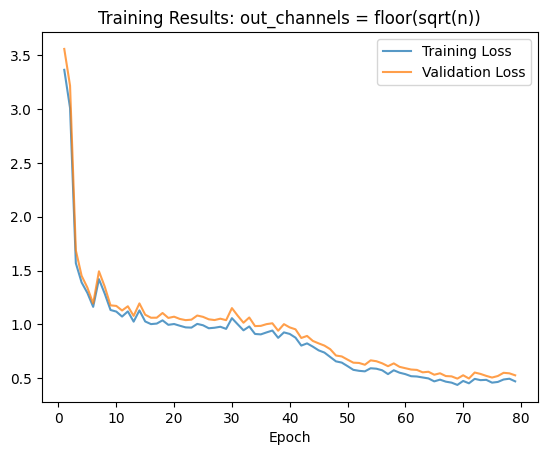

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3297, Validation Loss (MSE): 0.3644
Epoch: 020, Training Loss (MSE): 0.3025, Validation Loss (MSE): 0.3377
Epoch: 030, Training Loss (MSE): 0.2764, Validation Loss (MSE): 0.3102
Best Epoch: 028, Test Loss (MSE): 0.307410


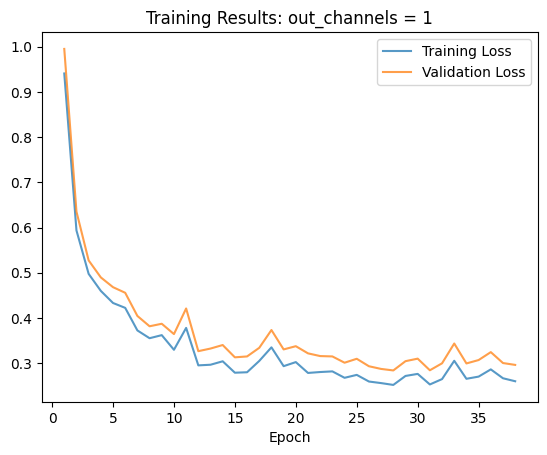

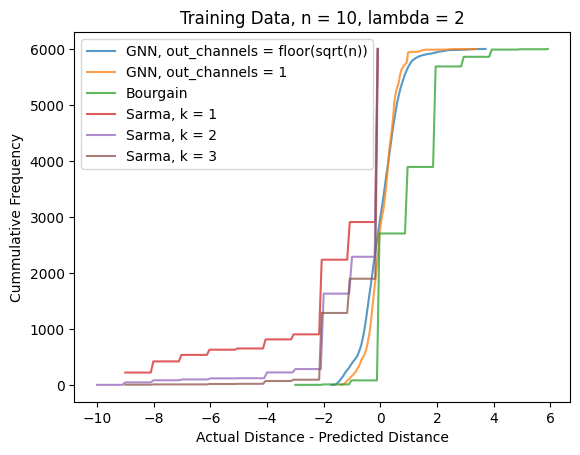

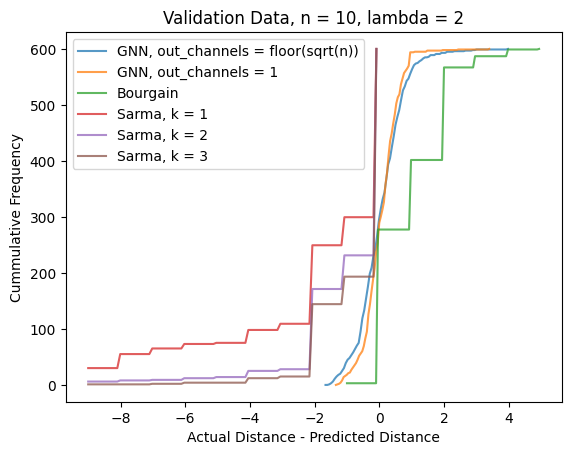

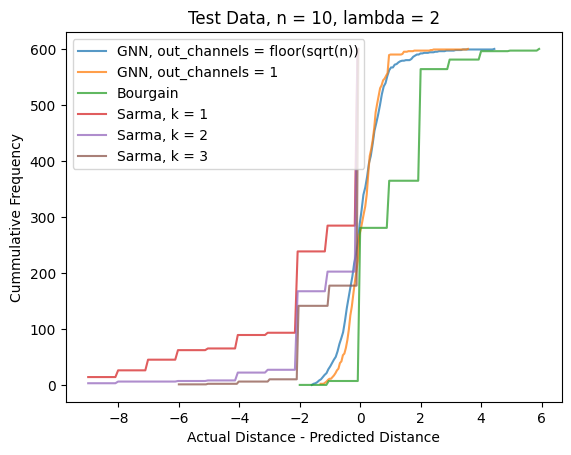

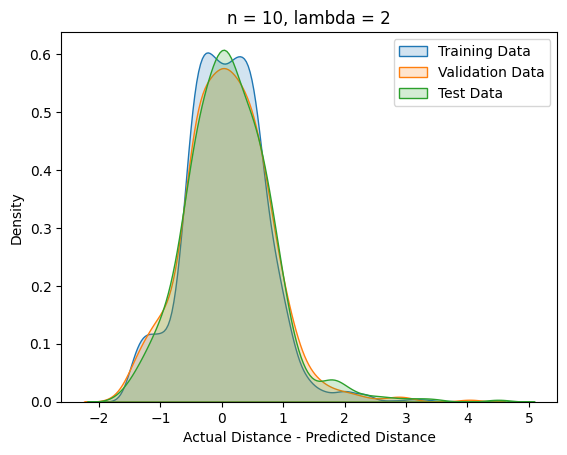

20
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  14
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  2
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  1
GCN(
  (conv1): GCNConv(4, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 4)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 1.7688, Validation Loss (MSE): 1.9054
Epoch: 020, Training Loss (MSE): 1.2269, Validation Loss (MSE): 1.2876
Epoch: 030, Training Loss (MSE): 1.1121, Validation Loss (MSE): 1.1673
Epoch: 040, Training Loss (MSE): 1.0159, Va

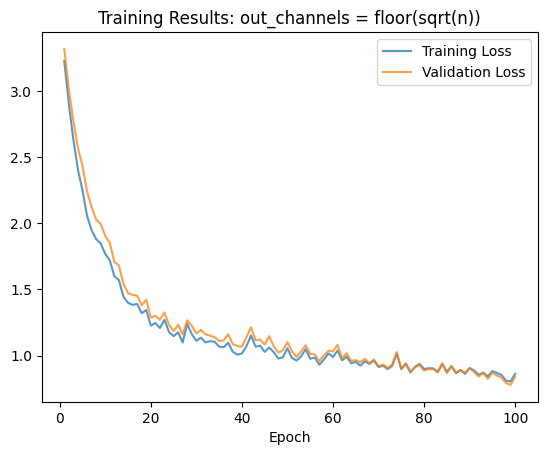

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.4617, Validation Loss (MSE): 0.4469
Epoch: 020, Training Loss (MSE): 0.3701, Validation Loss (MSE): 0.3403
Epoch: 030, Training Loss (MSE): 0.3219, Validation Loss (MSE): 0.3054
Epoch: 040, Training Loss (MSE): 0.3816, Validation Loss (MSE): 0.3389
Best Epoch: 030, Test Loss (MSE): 0.351949


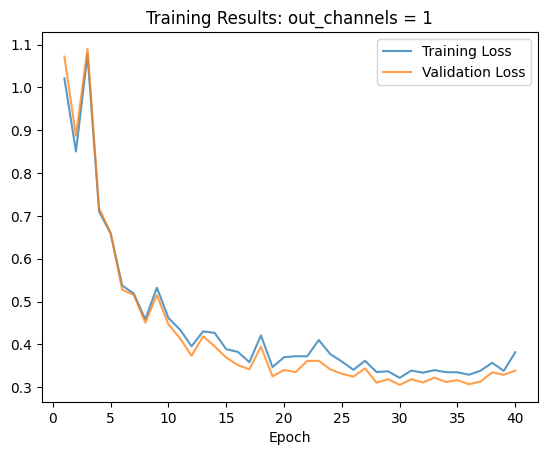

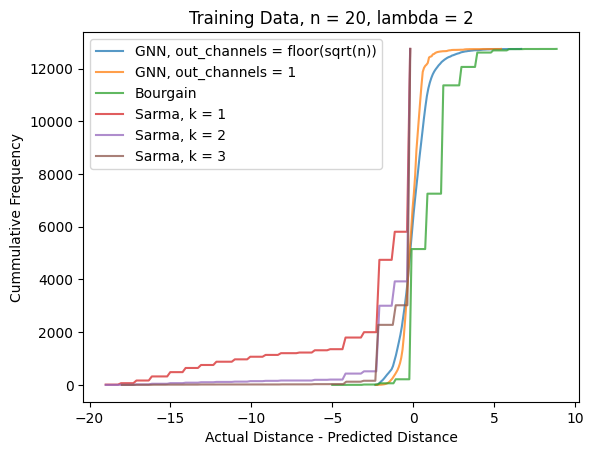

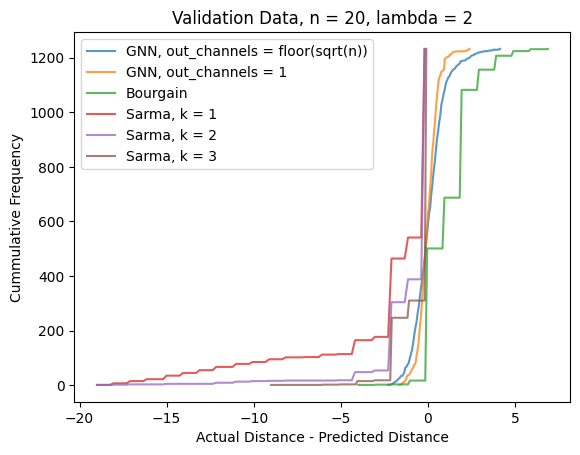

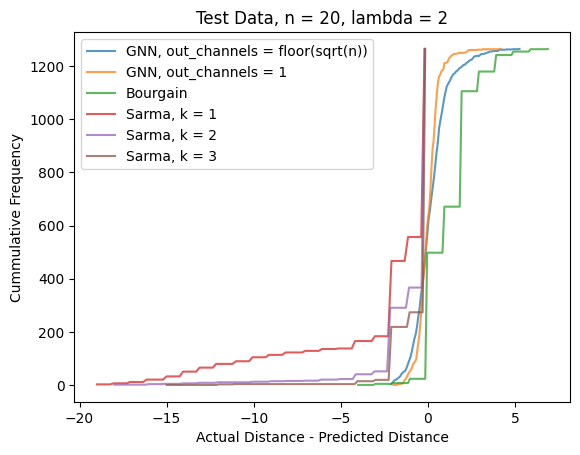

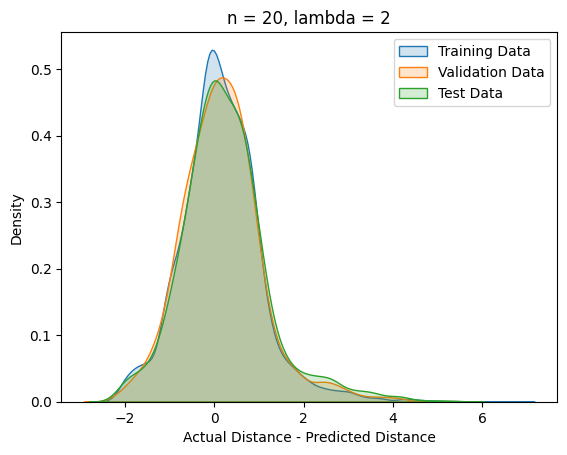

40
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(6, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 6)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 4.1221, Validation Loss (MSE): 3.6776
Epoch: 020, Training Loss (MSE): 3.7452, Validation Loss (MSE): 3.3950
Epoch: 030, Training Loss (MSE): 3.4461, Validation Loss (MSE): 3.0402
Epoch: 040, Training Loss (MSE): 3.0617, Val

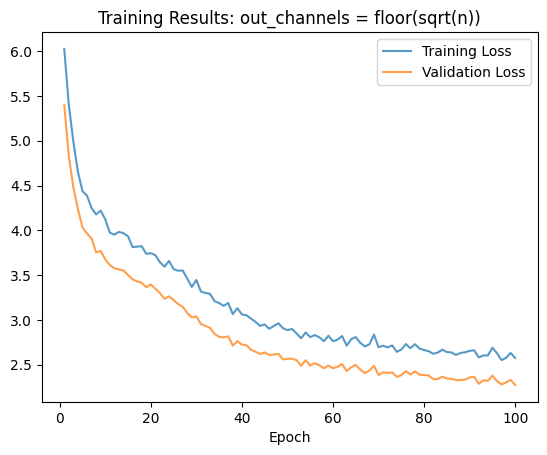

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.9072, Validation Loss (MSE): 0.6865
Epoch: 020, Training Loss (MSE): 0.8925, Validation Loss (MSE): 0.6822
Best Epoch: 016, Test Loss (MSE): 1.034027


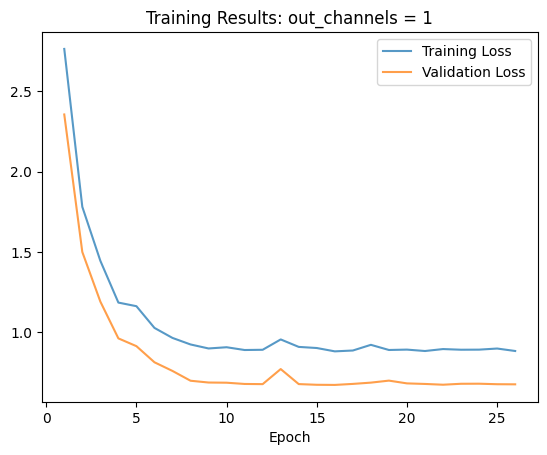

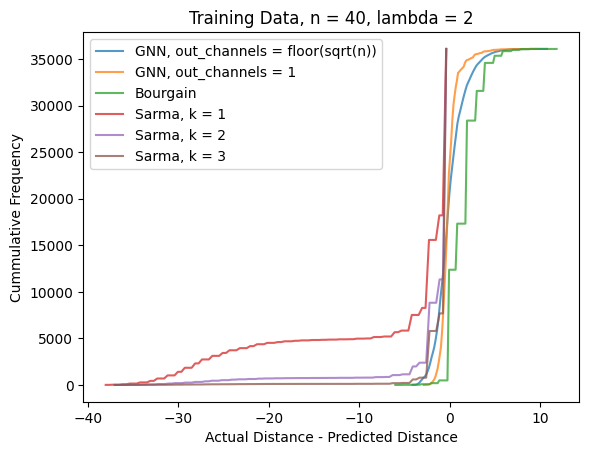

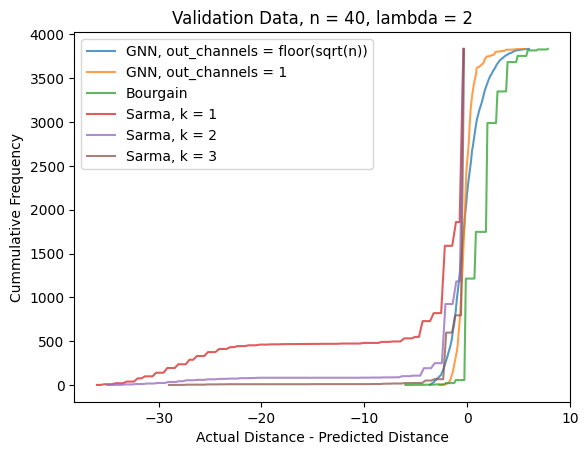

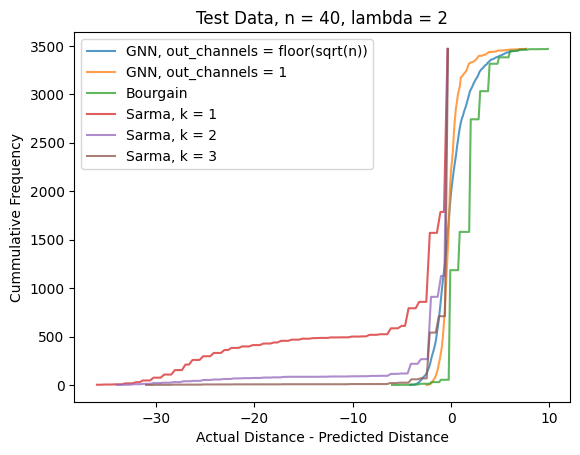

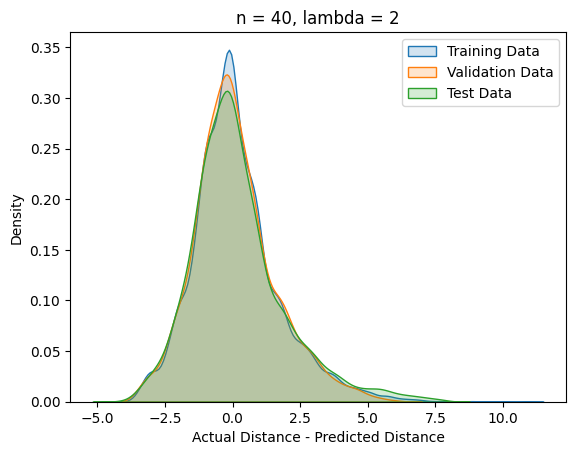

80
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(8, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 8)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 6.3182, Validation Loss (MSE): 6.4372
Epoch: 020, Training Loss (MSE): 5.6602, Validation Loss (MSE): 5.8177
Epoch: 030, Training Loss (MSE): 5.4084, Validation Loss (MSE): 5.5699
Epoch: 040, Training Loss (MSE): 5.3037, Val

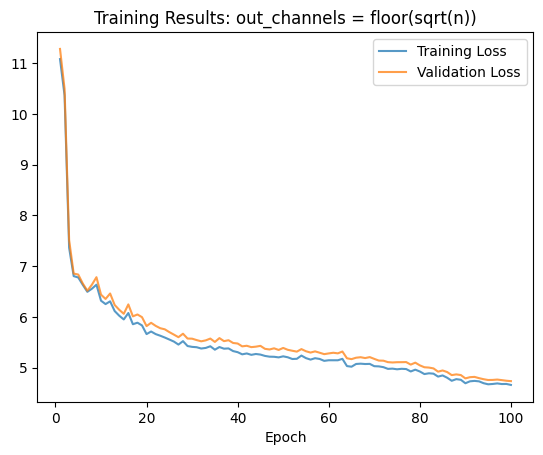

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 1.8664, Validation Loss (MSE): 1.8128
Best Epoch: 007, Test Loss (MSE): 1.736429


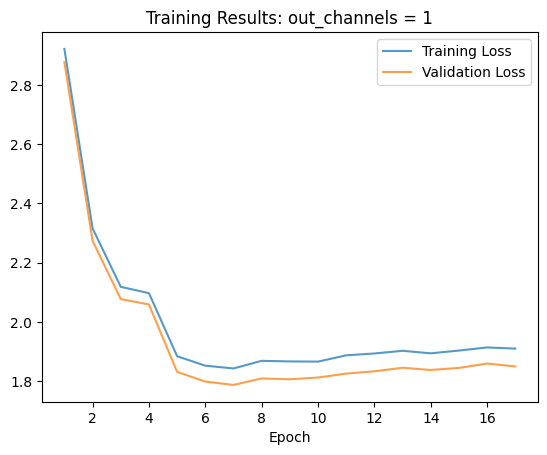

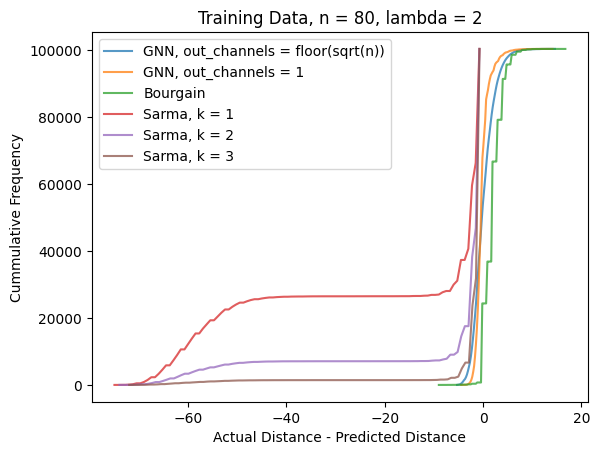

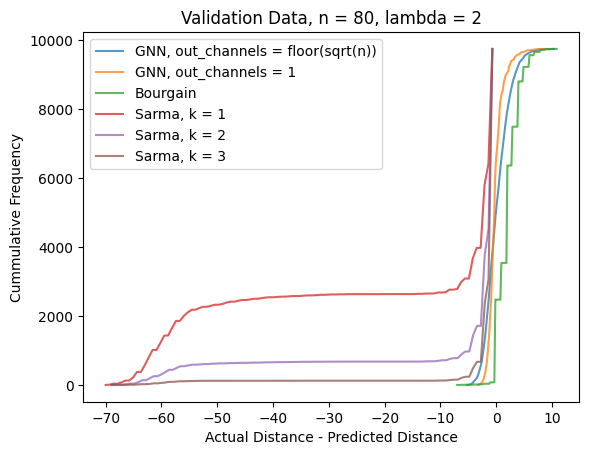

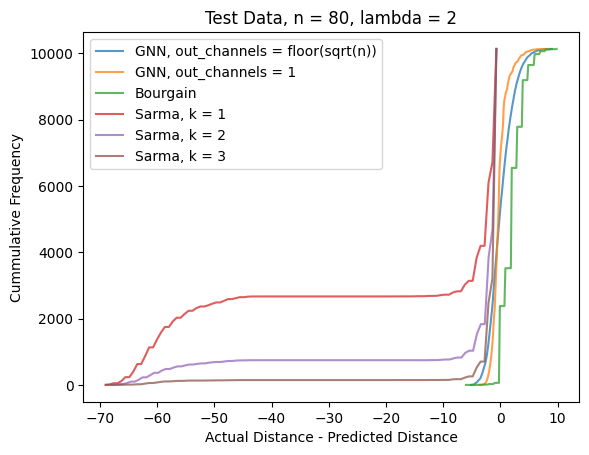

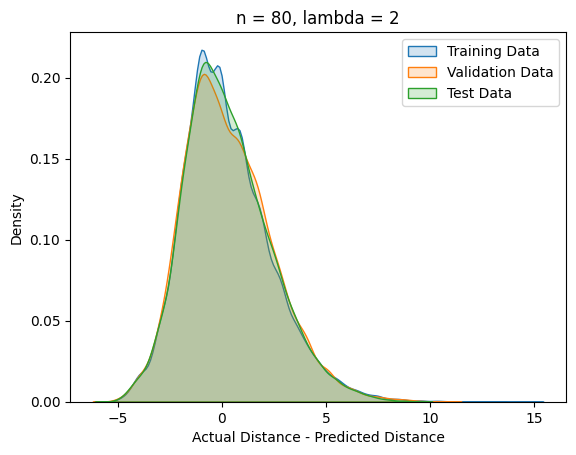

160
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(12, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 12)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 8.3068, Validation Loss (MSE): 7.4450
Epoch: 020, Training Loss (MSE): 7.8292, Validation Loss (MSE): 7.0229
Epoch: 030, Training Loss (MSE): 7.5454, Validation Loss (MSE): 6.7511
Epoch: 040, Training Loss (MSE): 7.2658, 

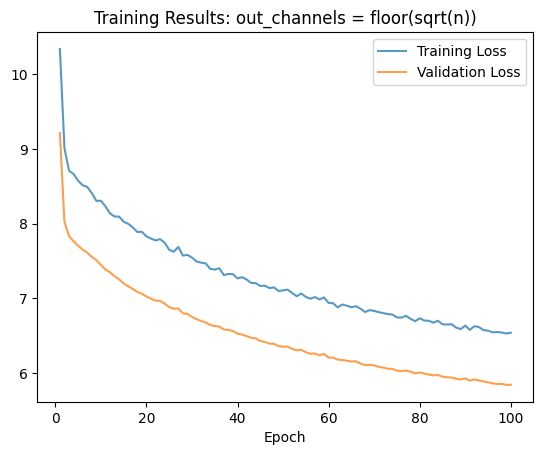

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 3.8047, Validation Loss (MSE): 3.1721
Epoch: 020, Training Loss (MSE): 3.5255, Validation Loss (MSE): 2.8963
Best Epoch: 018, Test Loss (MSE): 3.622892


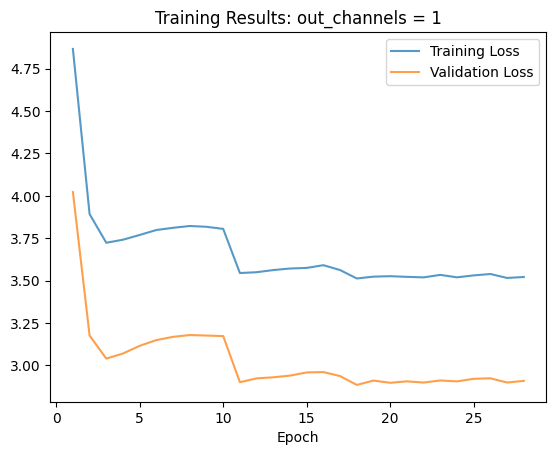

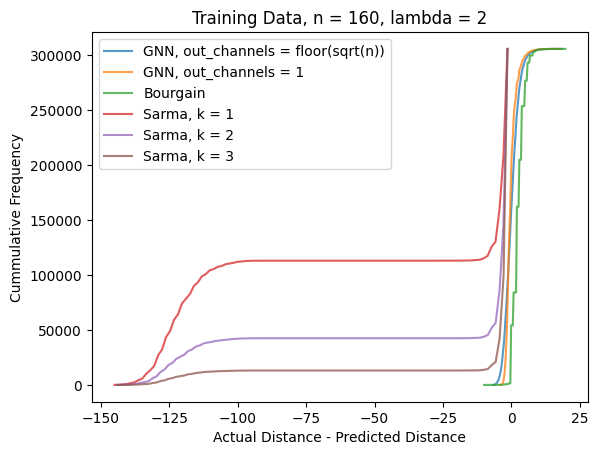

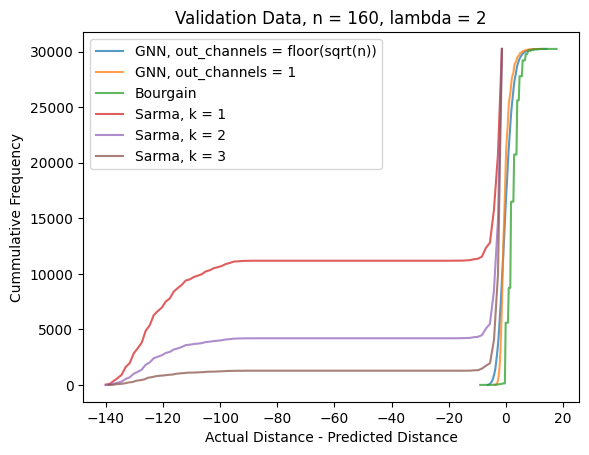

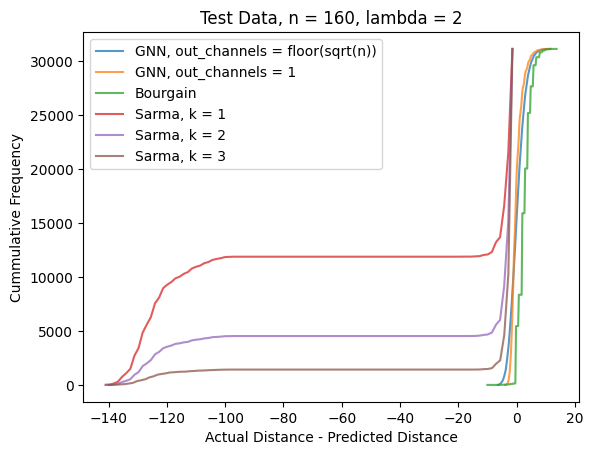

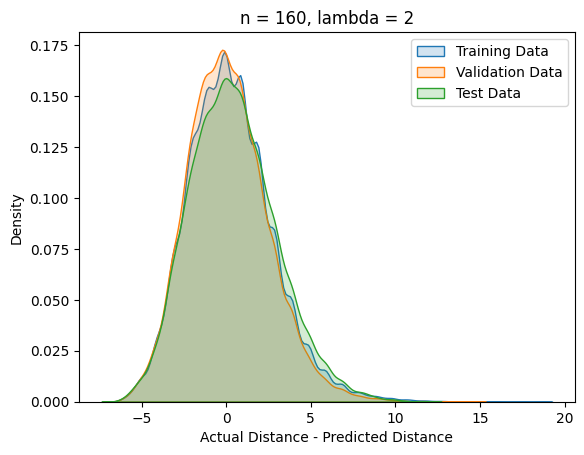

320
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(17, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 17)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 9.2430, Validation Loss (MSE): 9.6344
Epoch: 020, Training Loss (MSE): 8.6872, Validation Loss (MSE): 9.0685
Epoch: 030, Training Loss (MSE): 8.3593, Validation Loss (MSE): 8.7431
Epoch: 040, Training Loss (MSE): 8.1233, 

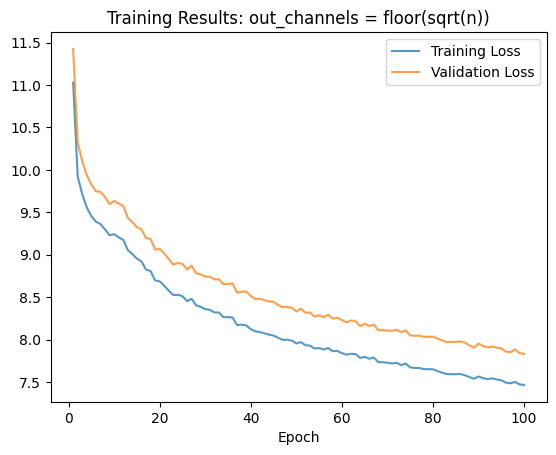

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 4.6386, Validation Loss (MSE): 4.9159
Epoch: 020, Training Loss (MSE): 4.6427, Validation Loss (MSE): 4.9058
Epoch: 030, Training Loss (MSE): 4.6624, Validation Loss (MSE): 4.9203
Best Epoch: 027, Test Loss (MSE): 5.498791


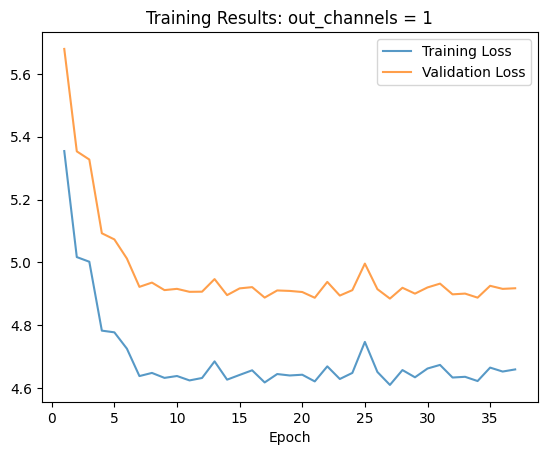

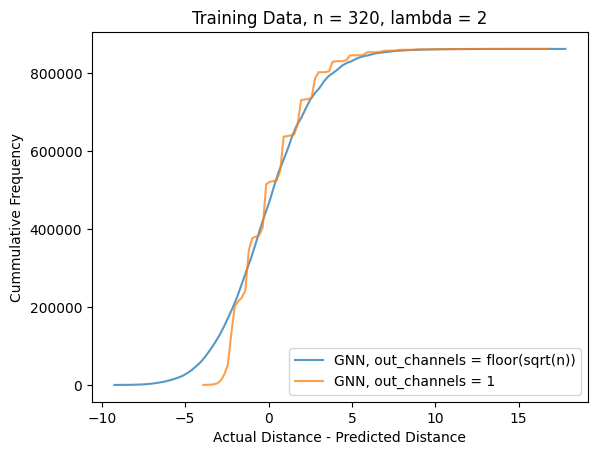

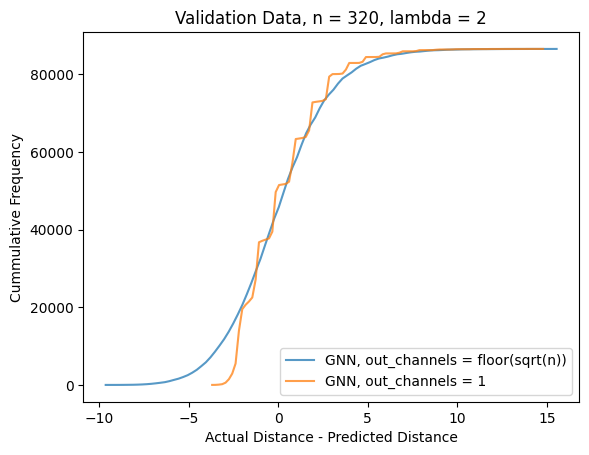

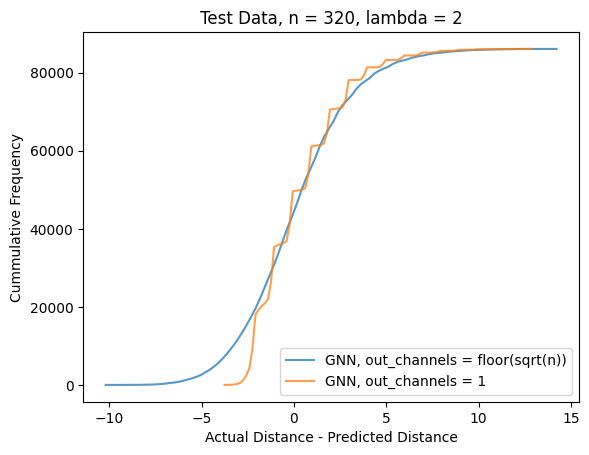

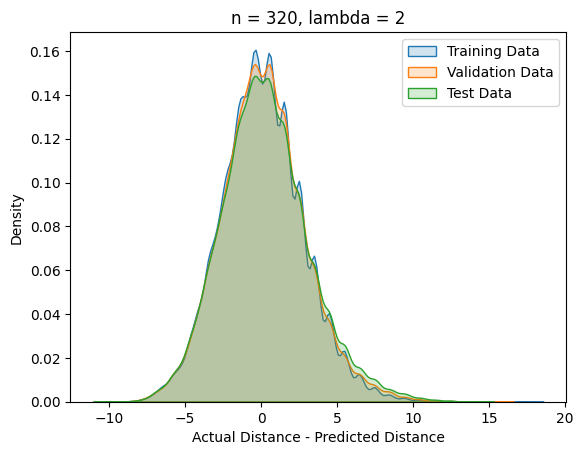

640
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(25, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 25)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 10.0473, Validation Loss (MSE): 10.3007
Epoch: 020, Training Loss (MSE): 9.2224, Validation Loss (MSE): 9.4522
Epoch: 030, Training Loss (MSE): 8.6428, Validation Loss (MSE): 8.8580
Epoch: 040, Training Loss (MSE): 8.3871

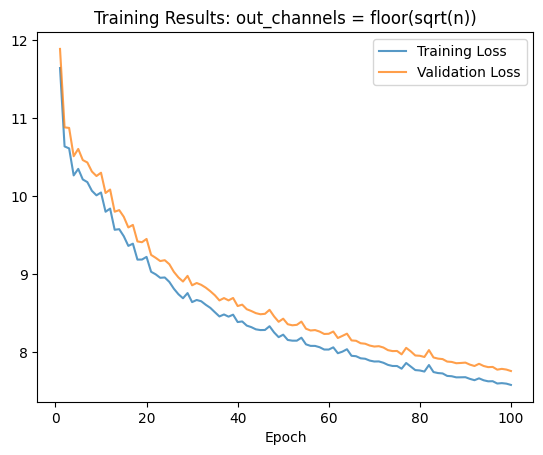

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 5.1518, Validation Loss (MSE): 5.2202
Best Epoch: 007, Test Loss (MSE): 4.679678


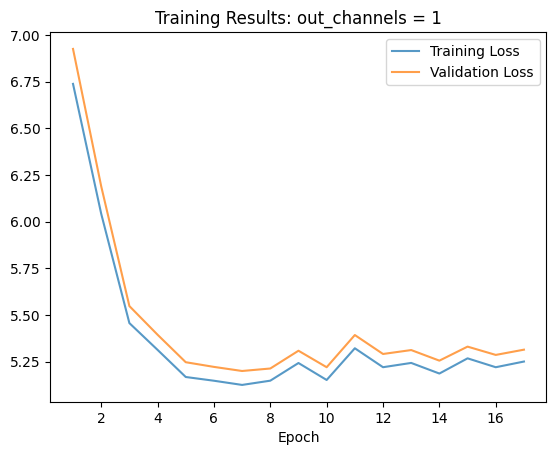

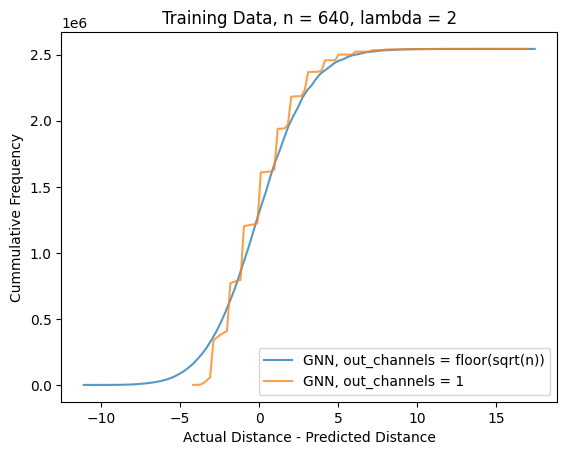

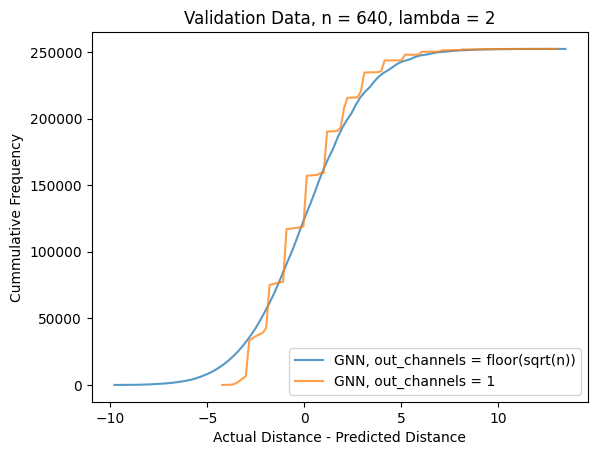

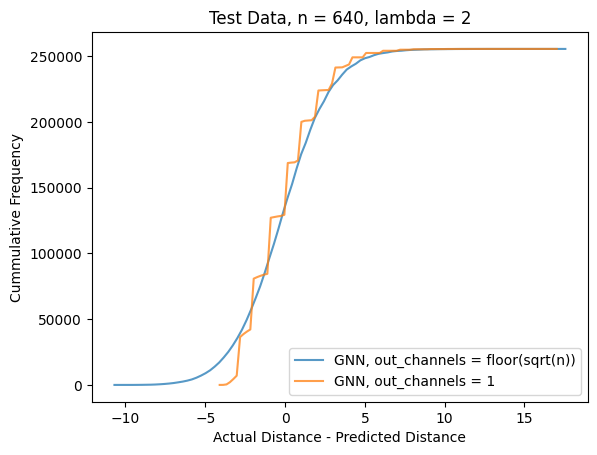

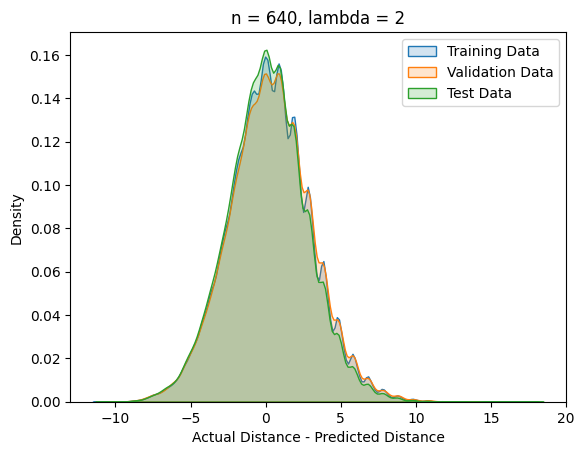

1280
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(35, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 35)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 10.1966, Validation Loss (MSE): 10.7050
Epoch: 020, Training Loss (MSE): 9.3790, Validation Loss (MSE): 9.8631
Epoch: 030, Training Loss (MSE): 8.9762, Validation Loss (MSE): 9.4487
Epoch: 040, Training Loss (MSE): 8.703

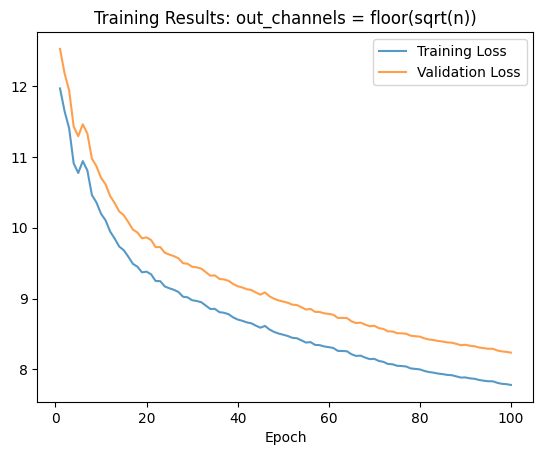

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 5.6018, Validation Loss (MSE): 6.0238
Epoch: 020, Training Loss (MSE): 5.5837, Validation Loss (MSE): 6.0091
Epoch: 030, Training Loss (MSE): 5.5741, Validation Loss (MSE): 5.9983
Epoch: 040, Training Loss (MSE): 5.5672, Validation Loss (MSE): 5.9912
Epoch: 050, Training Loss (MSE): 5.6239, Validation Loss (MSE): 6.0520
Best Epoch: 041, Test Loss (MSE): 5.641071


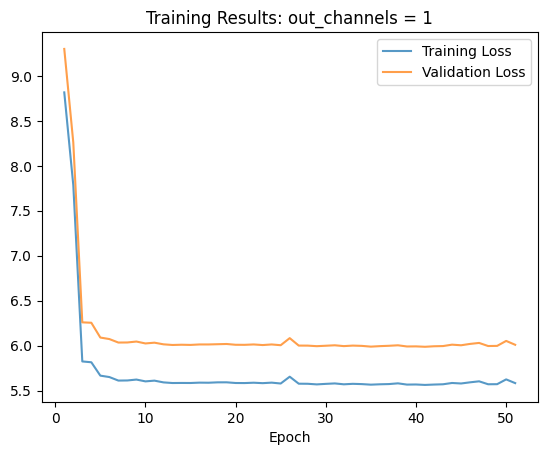

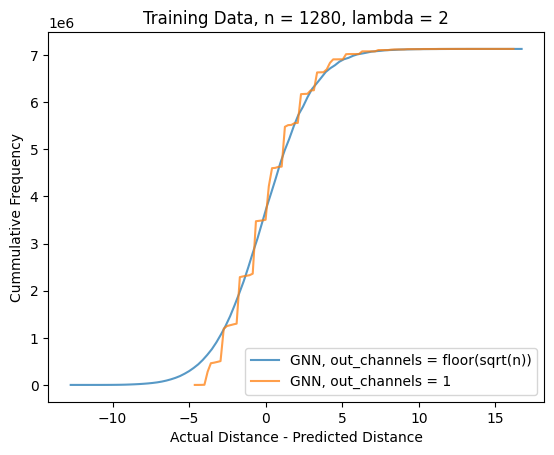

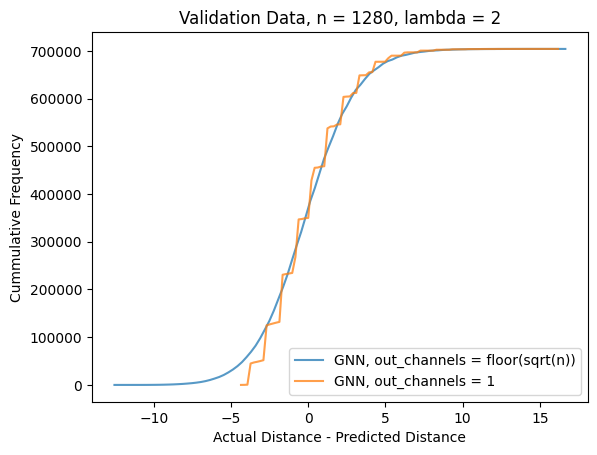

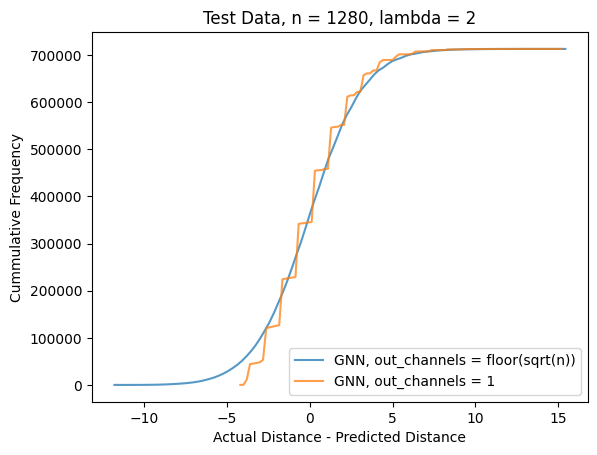

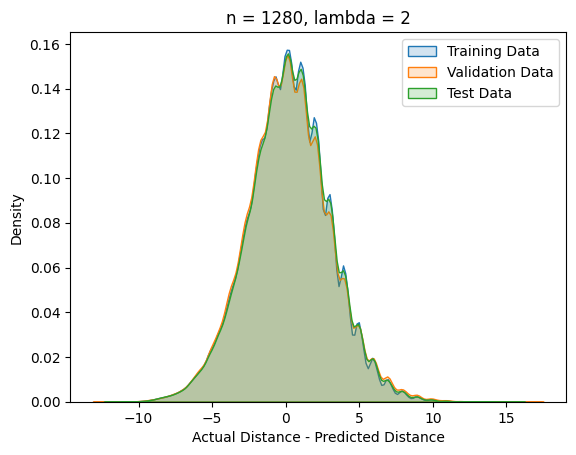

2560
Generating training data...


In [99]:
for n in [10,20,40,80,160,320,640,1280,1280*2,1280*4,1280*8,1280*16]:
    print(n)
    samples = generateERSamples(200,20,20,n)
    model1 = run(samples,'gcn','mse','adam','cyclic-cosine',100,10)
    model2 = run_out1(samples,'gcn','mse','adam','cyclic-cosine',100,10)
    evaluate(n,model1,model2,'mse',samples)

2560
Generating training data...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Number of graphs rejected b

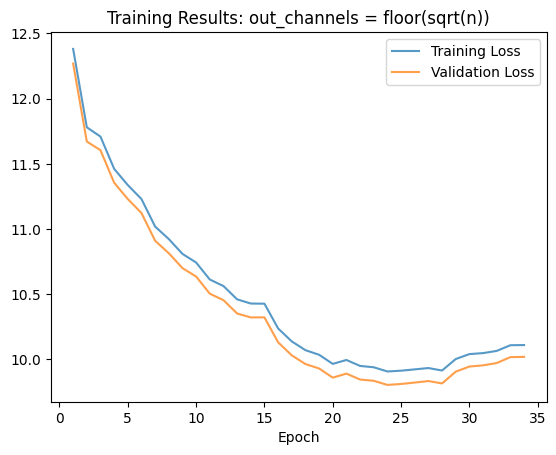

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 6.1587, Validation Loss (MSE): 6.0650
Epoch: 020, Training Loss (MSE): 6.1285, Validation Loss (MSE): 6.0375
Best Epoch: 015, Test Loss (MSE): 6.000394


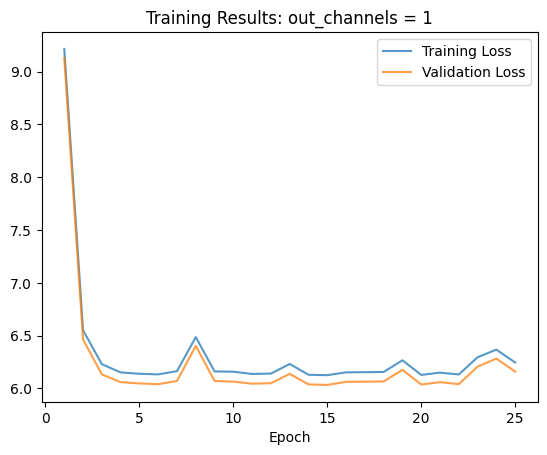

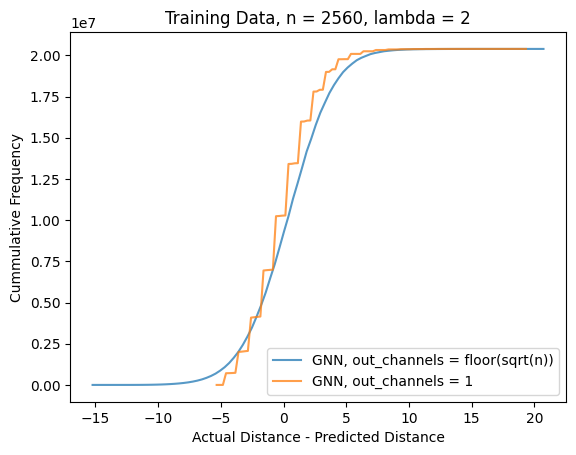

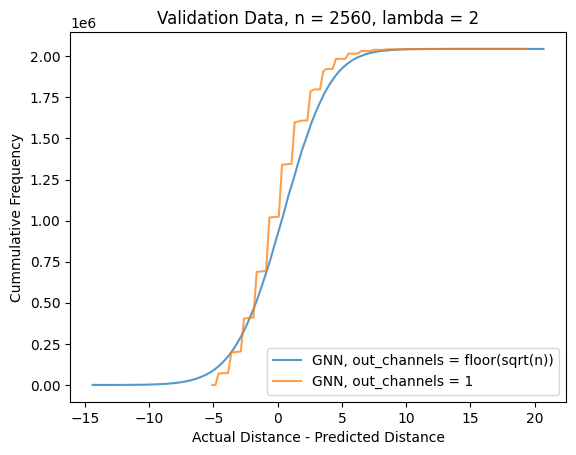

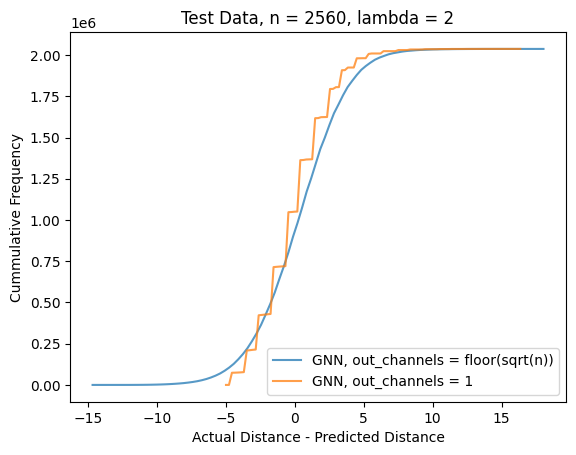

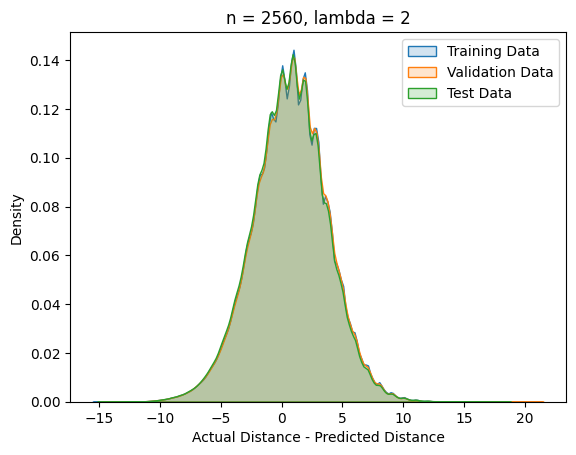

5120
Generating training data...
1
2
3
4
5


In [12]:
for n in [1280*2,1280*4,1280*8,1280*16]:
    print(n)
    samples = generateERSamples(200,20,20,n)
    model1 = run(samples,'gcn','mse','adam','cyclic-cosine',100,10)
    model2 = run_out1(samples,'gcn','mse','adam','cyclic-cosine',100,10)
    evaluate(n,model1,model2,'mse',samples)

In [11]:
for n in [1280*4,1280*8,1280*16]:
    print(n)
    samples = generateERSamples(200,20,20,n)
    model1 = run(samples,'gcn','mse','adam','cyclic-cosine',100,10)
    model2 = run_out1(samples,'gcn','mse','adam','cyclic-cosine',100,10)
    evaluate(n,model1,model2,'mse',samples)

5120
Generating training data...
1
2


In [ ]:
def allShortestDistances_directed(i,j,d_ki,d_ij,d_jk):
    n = len(d_ki)
    distances =  np.zeros((n,n))
    for u in range(n):
        for v in range(n):
            if u != v:
                distances[u,v] = d_ki[u]+d_ij+d_jk[v]
    distances[i,j] = min(distances[i,j],d_ij)
    return distances

def allShortestDistances_undirected(i,j,d_ki,d_jk):
    if i == j:
        d_ij = 0
    else:
        d_ij = min(d_ki[j],d_jk[i])
    n = len(d_ki)
    distances =  np.zeros((n,n))
    for u in range(n):
        for v in range(u+1,n):
            distances[u,v] = min(d_ki[u]+d_ki[v],d_jk[u]+d_jk[v],d_ki[u]+d_ij+d_jk[v],d_ki[v]+d_ij+d_jk[u])
            distances[v,u] = distances[u,v]
    distances[i,j] = min(distances[i,j],d_ij)
    distances[j,i] = distances[i,j]
    return distances

def ShortestPath(G,distances,u,v,epsilon):
    S = [u,v]
    for k in range(distances.shape[0]):
        if np.abs(distances[u,k]+distances[k,v]-distances[u,v]) <= epsilon:
            S.append(k)
    S.sort()
    if not isinstance(G, np.ndarray):
        subgraph = G.subgraph(S)
        if nx.has_path(subgraph, u, v):
            path = nx.shortest_path(subgraph, u, v, weight="weight")
            distance = nx.shortest_path_length(subgraph, u, v, weight="weight")
            return path, distance
        else:
            return None, None
    else:
        subgraph = G[S]
        subgraph = subgraph[:,S]
        subgraph = matrix_to_graph(subgraph)
        u_masked = S.index(u)
        v_masked = S.index(v)
        if nx.has_path(subgraph, u_masked, v_masked):
            path = nx.shortest_path(subgraph, u_masked, v_masked, weight="weight")
            distance = nx.shortest_path_length(subgraph, u_masked, v_masked, weight="weight")
            return [S[i] for i in path], distance
        else:
            return None, None

In [ ]:
## Sarma claimed that there is at least one common node in SKETCH[u] and SKETCH[v] for undirected connected graphs. This is FALSE!!
import numpy as np
def checkSarmaAssumption(n,k):
    r = int(np.floor(np.log(n))) ## which base? use e instead of 10 this time since it returns a higher r, lowering the possibility of having no common nodes.
    seed_sizes = 2**np.array(list(range(r+1))*k)
    max_nodes_to_considered = (np.sum(seed_sizes)+1)*2
    boolean = n>max_nodes_to_considered
    return boolean
k1 = []
k2 = []
k3 = []
for n in range(1,100000):
    k1.append(checkSarmaAssumption(n,1))
    k2.append(checkSarmaAssumption(n,2))
    k3.append(checkSarmaAssumption(n,3))
print(np.sum(k1))
print(np.sum(k2))
print(np.sum(k3))